# Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation

In this project, we will create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. I will implement the following techniques that I have learned:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimize overfitting
- Generating and analyzing precision recall curves


In [112]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam). 

The labeled dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email
1. `email`: The text of the email.
1. `spam`: 1 if the email was spam, 0 if the email was ham (not spam).

The `test` DataFrame contains another set of 1000 unlabeled examples.

In [113]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Mon Dec 17 11:45:10 2018
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Mon Dec 17 11:45:11 2018
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First let's check if our data contains any nan values. If there are nan values, I will replace them with the appropriate filler values. In other words, a nan value in the subject column should be replaced with an empty string. 

Note that while there are no nan values in the spam column, we should be careful when replacing nan values when they are the labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [114]:
for i in original_training_data.columns.values:
    if sum(original_training_data[i].isnull()) > 0:
        print(i, "has NaN values")
        original_training_data[i] = original_training_data[i].replace(np.nan, "", regex = True)

subject has NaN values


In [115]:
first_ham = original_training_data[original_training_data["spam"] == 0].iloc[0]['email']
first_spam = original_training_data[original_training_data["spam"] == 1].iloc[0]["email"]
print(first_ham)


url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 



Printed above is the first ham email in our dataset. We see that it looks like a pretty standard email.

In [116]:
print(first_spam)

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



This is an example of a spam email. We see it uses html, head, and body tags. The email itself also seems to be an advertisement.

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers. 

In [117]:
from sklearn.model_selection import train_test_split

[train, val] = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the text is ham or spam. This is a *classification* problem, so we can use logistic regression to make a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $\Phi$ (pronounced phi as in wifi) and corresponding binary labels $Y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\Phi$ is derived from one email example. Each column of $\Phi$  is one feature. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

We will create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It will output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```python
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello world hello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [118]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for i in texts:
        indicator_array.append(np.array([word in i for word in words]).astype(int).tolist())
    return np.array(indicator_array)

# Basic EDA

Now we need to identify some features that allow us to tell spam and ham emails apart. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


Text(0,0.5,'Proportion of Emails')

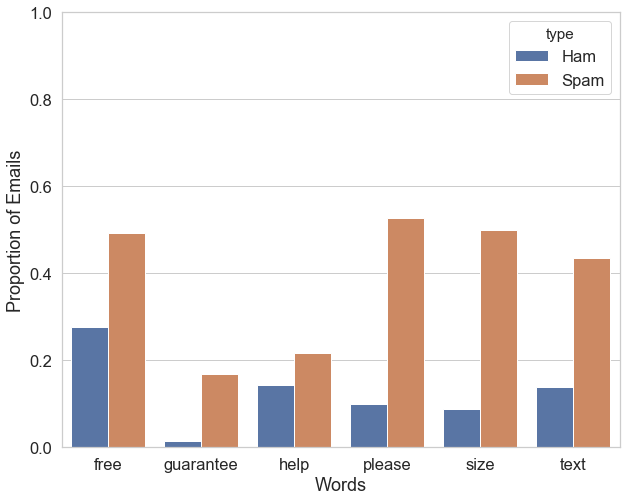

In [119]:
train=train.reset_index() # We must do this in order to preserve the ordering of emails to labels for words_in_texts
words = ['size', 'guarantee', 'help', 'please', 'free', 'text']

spam = pd.DataFrame(words_in_texts(words, train[train['spam'] == 1]['email']), columns = words).melt()
spam_grouped = spam.groupby('variable').agg('sum')
spam_grouped['proportion'] = spam_grouped['value']/len(train[train['spam'] == 1])
spam_grouped['type'] = ['Spam']*len(words)

ham = pd.DataFrame(words_in_texts(words, train[train['spam'] == 0]['email']), columns = words).melt()
ham_grouped = ham.groupby('variable').agg('sum')
ham_grouped['proportion'] = ham_grouped['value']/len(train[train['spam'] == 0])
ham_grouped['type'] = ['Ham']*len(words)

final_df = ham_grouped.append(spam_grouped).reset_index()

plt.figure(figsize = (10, 8))
sns.barplot('variable', 'proportion', ci=None, hue = 'type', data = final_df)
plt.yticks(np.arange(0, 1.1, .2))
plt.xlabel("Words")
plt.ylabel("Proportion of Emails")


C:\Users\Chris Tsai\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Distribution')

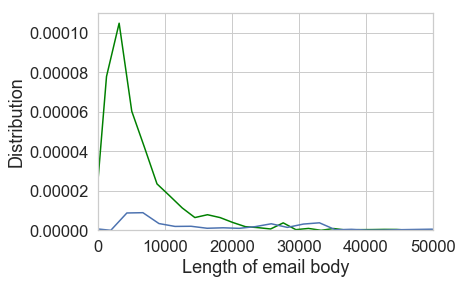

In [120]:
body_length = []
for i in train.index:
    body_length.append(len(train['email'][i]))
train["length"] = body_length
spam_length = train[train['spam'] == 1]
ham_length = train[train['spam'] == 0]
sns.distplot(spam_length['length'], hist = False, color = "green")
sns.distplot(ham_length['length'], hist = False)
plt.xlim(0, 50000)
plt.xlabel("Length of email body")
plt.ylabel("Distribution")

We can see that the distribution of spam emails are skewed right; The majority of spam email have lengths 0 to 10000, while ham emails have more spread out lengths.

In [121]:
import sklearn
import sklearn.datasets
import sklearn.linear_model


# Basic Classification

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. Since we are trying  There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

Before creating our final model, we should think about ways to improve the filtering of spam and ham emails. Some ideas include:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

# Feature Engineering


### Word Length
The first feature that I wanted to create was detecting extremely long words. In a lot of spam emails, there are words that are just a random assortment of letters, and if I can detect these nonsensical words, my model can easily classify them as spam. getWords is a function that seperates every word in a text as an element in a list. long_words is a function that takes in a dataframe and first cleans each text for any regular expression patterns and then uses getWords to return a cleaned list of words for each text. Then, it returns 1 for texts that have words which exceed 20 characters and 0 otherwise.

In [122]:
import re
def getWords(text):
    return re.compile('\w+').findall(text)

def long_words(df):
    #replace all punctuation
    cleaned_text = []
    for s in range(len(df)):
        cleaned_text.append(re.sub(r'[^\w\s]',' ', df.iloc[s]["email"]))
        cleaned_text[s] = re.sub(r'_', ' ', cleaned_text[s])
        cleaned_text[s] = re.sub(r"\n", " ", cleaned_text[s])
        cleaned_text[s] = re.sub(r"\t", " ", cleaned_text[s])
    too_long = []
    for x in range(len(cleaned_text)):
        if max([len(i) for i in getWords(cleaned_text[x])]) > 20:
            too_long.append(1)
        else:
            too_long.append(0)
    return too_long

### Words
The second feature that I wanted to create was just words in general. Having more and more words as features is a good way for our model to differentiate which words are used more in spam emails/ham emails. For that reason, I used the 1100 most common words found in our training set. In theory, the more words we use, the more we overfit our training model, as having too many features can cause overfitting. However, with a training set this large and a test set even larger, I think that this is fine.


In [123]:
from collections import Counter
a = Counter(" ".join(train[train["spam"] == 1]["email"]).split()).most_common(1100)
a.remove(a[102]) #We are removing these because they are characters that interfere with str.contains
a.remove(a[319]) #These are regular expression characters such as *, **, etc.
a.remove(a[402])
a.remove(a[546])
a.remove(a[523])


body_words = []
for i in range(len(a)):
    body_words.append(a[i][0])


I ended up not using subject_word as a feature, since it had too much random correlation with body_words, which led to a much lower accuracy.

In [124]:
b = Counter(" ".join(train[train["spam"] == 1]["subject"]).split()).most_common(100)

subject_word = []
for i in range(len(b)):
    subject_word.append(b[i][0])


#I ended up not using these features

### Punctuation and Symbols
The third feature that I wanted to use was finding punctuation in both the subject and email body. The types of punctuation that I used were:
    
    
    "!", ".", ":", "?", "$", "%"


In [125]:
def punctuation_subject(df):
    cleaning = df["subject"].str.replace("Subject:", "") #getting rid of the Subject: tag in the subject
    cleaning = cleaning.str.replace("Re:", "") #getting rid of the Re: tag in the subject
    clean = cleaning.replace(np.nan, " ", regex = True)

    punctuation_subject = []
    for i in df.index:
        punctuation_subject.append((len("".join([c for c in clean[i] if c == "!" or c == "." or c == ":" or 
                                                 c == "?" or c == "$" or c == "%"]))))
    return punctuation_subject



def punctuation_body(df):
    punctuation_body = []
    for i in df.index:
        punctuation_body.append((len("".join([c for c in df["email"][i] if c == "!" or c == "." or c == ":" or
                                              c == "?" or c == "$" or c == "%"]))))
    return punctuation_body



### Length of Texts and Uppercase in Subject
The fourth type of feature I wanted to implement was the length of the text in both the subject and email body and also the number of uppercase letters in the subject.

In [126]:
def subject_length(df):
    cleaning = df["subject"].str.replace("Subject:", "") #getting rid of the Subject: tag in the subject
    cleaning = cleaning.str.replace("Re:", "") #getting rid of the Re: tag in the subject
    clean = cleaning.replace(np.nan, " ", regex = True)
    subject_len = []
    for i in df.index:
        subject_len.append(len(clean[i]))
    return subject_len



def body_length(df):
    body_len = []
    for i in df.index:
        body_len.append(len(df['email'][i]))
    return body_len



def uppercase(df):
    cleaning = df["subject"].str.replace("Subject:", "") #getting rid of the Subject: tag in the subject
    cleaning = cleaning.str.replace("Re:", "") #getting rid of the Re: tag in the subject
    clean = cleaning.replace(np.nan, " ", regex = True)
    uppercase = []
    for i in df.index:
        uppercase.append((len("".join([c for c in clean[i] if c.isupper()]))))
    return uppercase
    

# Creating and Choosing our Model
We now use all of the features defined above to create our feature matrix. We initially use all of the features we defined above, but we will show that not all of the features are very useful through cross-validation.

In [127]:
def features(df): 
    features = pd.DataFrame(words_in_texts(body_words, df["email"]), columns = body_words)
    features["punctuation_subject"] = punctuation_subject(df)
    features["punctuation_body"] = punctuation_body(df)
    features["uppercase"] = uppercase(df)
    features["body_length"] = body_length(df)
    features["subject_length"] = subject_length(df)
    features["long_words"] = long_words(df)
    
    return features

response = train['spam']

feature = features(train)


In [128]:
model = sklearn.linear_model.LogisticRegression(fit_intercept=True)
fitted = model.fit(feature, response)
predicted = fitted.predict(feature)

train_pred = fitted.predict_proba(feature)
spam_prob = train_pred[:, 1]

train_correct = sum((predicted == 1) & (response == 1)) + sum((predicted == 0) & (response == 0))
train_correct/len(train)

print("The accuracy of our initial model on our training set is " + str(sum(predicted == response)/len(train)))

The accuracy of our initial model on our training set is 0.9994675895115134


# 10-Fold Cross Validation
To see if our model can do better with or without some features, we implement 10-fold cross validation. 10-fold cross validation splits our training set into 10 groups. 10-fold CV iterates over a set 10 times, each time choosing a different validation set, while holding the rest as the training set.

In [129]:
from sklearn.model_selection import KFold

def CV_accuracy(X_train, Y_train):
    kf = KFold(n_splits = 10)
    validation_errors = []

    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx] 
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
    
    model = sklearn.linear_model.LogisticRegression(fit_intercept=True)
    model.fit(split_X_train, split_Y_train)
    Y_pred = model.predict(split_X_valid)
    accuracy = sum(Y_pred == split_Y_valid)/len(Y_pred)
    validation_errors.append(accuracy)

    return np.mean(validation_errors)

In [130]:
acc = []
acc.append(CV_accuracy(feature.loc[:, "the": "confidential"], response))
acc.append(CV_accuracy(feature.drop(columns = ["punctuation_subject", "subject_length"], axis = 1), response))
acc.append(CV_accuracy(feature.drop(columns =
                         ["punctuation_subject", "punctuation_body", "body_length", "subject_length", "uppercase"],
                         axis = 1), response))
acc.append(CV_accuracy(feature.drop(columns =
                         ["punctuation_subject", "body_length", "uppercase"],
                         axis = 1), response))
feature_sets = ["Word Features", "Without Subject Features", "Word Features and Word Length",
              "Without Subject Punctuation, Body Length, and Uppercase"]
for i in range(4):
    print('{}, accuracy: {}'.format(feature_sets[i], acc[i]))


Word Features, accuracy: 0.9973368841544608
Without Subject Features, accuracy: 0.9933422103861518
Word Features and Word Length, accuracy: 0.9986684420772304
Without Subject Punctuation, Body Length, and Uppercase, accuracy: 0.9986684420772304


### Feature Selection

It seems like the model that does the best is one that drops the features: 

Subject Punctuation, Body Length, and Uppercase

We will now use our new features to train our model, and test the accuracy of the training set.

In [131]:
model = sklearn.linear_model.LogisticRegression(fit_intercept=True)
new_feature = feature.drop(columns =
                         ["punctuation_subject", "body_length", "uppercase"],
                         axis = 1)
new_fitted = model.fit(new_feature, response)
predicted = new_fitted.predict(new_feature)

train_pred = new_fitted.predict_proba(new_feature)
spam_prob = train_pred[:, 1]

train_correct = sum((predicted == 1) & (response == 1)) + sum((predicted == 0) & (response == 0))
train_correct/len(train)

sum(predicted == response)/len(train)

1.0

In [132]:
val_test = features(val).drop(columns =
                         ["punctuation_subject", "body_length", "uppercase"],
                         axis = 1)
val_predictions = new_fitted.predict(val_test)
val_correct = sum((val_predictions == 1) & (val["spam"] == 1)) + sum((val_predictions == 0) & (val["spam"] == 0))
val_correct/len(val)

0.9940119760479041

# Making a Precision-Recall Curve

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

Since we achieved such a high accuracy on our training set and validation set, it is fair to say that we do not need to make any adjustments to our cutoff. I have still plotted the curve below, and since there is no tradeoff, our curve looks like a right angle.

1.0

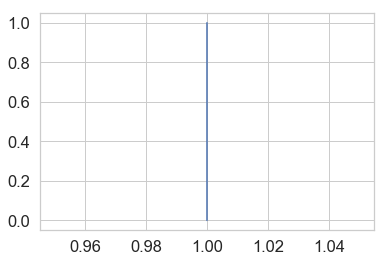

In [133]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(response, spam_prob)

plt.plot(precision, recall)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(response, spam_prob)
average_precision

# Results
I participated in a classwide competition on Kaggle for the best ham/spam classifer, and out of 500+ students, I tied 4th on the private leaderboards with an accuracy of .99714.

https://www.kaggle.com/c/ds100-fa18-hw4/leaderboard